In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import os
# import import_ipynb 
# from preprocessing import img_data , labels

In [2]:


IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 85  # Number of species

# Path to the dataset folder
data_dir = "d:/working_mani/dataset"

# Initialize lists to hold file paths and labels
file_paths = []
labels = []

# Iterate over each species folder
for label, species_folder in enumerate(sorted(os.listdir(data_dir))):
    species_path = os.path.join(data_dir, species_folder)
    if os.path.isdir(species_path):
        # List all image files in the species folder
        all_images = sorted(os.listdir(species_path))
        # Select the first 75 images
        selected_images = all_images[:75]
        # Skip the next 25 images and select the following 75 images
        selected_images += all_images[100:175]
        # Append the full path and label for each selected image
        for img in selected_images:
            file_paths.append(os.path.join(species_path, img))
            labels.append(label)

# Convert lists to TensorFlow datasets
file_paths_ds = tf.data.Dataset.from_tensor_slices(file_paths)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)

# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, IMG_SIZE)
    # Normalize the image to [0, 1]
    img = img / 255.0
    return img

# Apply the function to the file paths
images_ds = file_paths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Combine images and labels into a single dataset
dataset = tf.data.Dataset.zip((images_ds, labels_ds))

# Function to one-hot encode labels
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

# Apply one-hot encoding to the labels
dataset = dataset.map(one_hot_encode, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(file_paths)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check the class names to see the full list of plant categories
class_names = sorted(os.listdir(data_dir))
print("Class names:", class_names)

# Extract images and labels from the dataset
images, labels = zip(*[(img.numpy(), label.numpy()) for img, label in dataset.unbatch()])
images = np.array(images)
labels = np.array(labels)


Class names: ['Aloevera', 'Amar poi', 'Amla', 'Amruta_Balli', 'Arali', 'Ashoka', 'Ashwagandha', 'Astma_weed', 'Avacado', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Basale', 'Beans', 'Betel', 'Betel_Nut', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue', 'Coriender', 'Curry_Leaf', 'Doddapatre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganike', 'Gasagase', 'Geranium', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemon_grass', 'Malabar_Nut', 'Mango', 'Marigold', 'Mint', 'Nagadali', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomegranate', 'Pumpkin', 'Raddish', 'Raktachandini', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'Wood_sorel', 'camphor', 'kamakastur

In [3]:

# Split data into training (75%), validation (15%), and testing (10%)
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images,labels, test_size=0.25, random_state=42,stratify=labels
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.4, random_state=42,stratify=temp_labels
)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [4]:
# Batch and prefetch datasets for performance
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


Training set size: 9562
Validation set size: 1912
Test set size: 1276


In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# Load VGG16 model without top layers
base_model = tf.keras.applications.VGG16(include_top=False, 
                                         weights='imagenet', 
                                         input_shape=(224, 224, 3))
base_model.trainable = False
# Unfreeze last few convolutional layers for fine-tuning
for layer in base_model.layers[-5:]:  
    layer.trainable = True

# Create model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())

# Fully connected layers with L2 regularization and batch normalization
model.add(layers.Dense(1024, kernel_regularizer=l2(0.0005)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, kernel_regularizer=l2(0.0005)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, kernel_regularizer=l2(0.0005)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, kernel_regularizer=l2(0.0005)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, kernel_regularizer=l2(0.0005)))  
model.add(layers.BatchNormalization())  
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(85, activation='softmax'))  

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()


c:\Users\Satnam\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 85)             │        21,84

 Total params: 16,058,773 (61.26 MB)

 Trainable params: 8,418,901 (32.12 MB)

 Non-trainable params: 7,639,872 (29.14 MB)

In [7]:
initial_epochs = 40
validation_steps = 20

from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_loss",      # Metric to monitor (e.g., validation loss)
    patience=3,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True    # Restore the best weights when stopping
)
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, verbose=1)

history = model.fit(
    train_dataset, 
    epochs=initial_epochs, 
    validation_data=val_dataset,  # Pass validation data
    validation_steps=validation_steps,
    callbacks=[early_stopping,lr_scheduler]
)
loss0, accuracy0 = model.evaluate(test_dataset)
print(f"Initial test Loss: {loss0}")
print(f"Initial test Accuracy: {accuracy0}")

Epoch 1/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.0171 - loss: 6.1713 - val_accuracy: 0.0344 - val_loss: 5.3796 - learning_rate: 1.0000e-04
Epoch 2/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.0176 - loss: 5.8816 - val_accuracy: 0.0672 - val_loss: 5.2445 - learning_rate: 1.0000e-04
Epoch 3/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.0293 - loss: 5.6347 - val_accuracy: 0.1078 - val_loss: 4.9730 - learning_rate: 1.0000e-04
Epoch 4/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.0459 - loss: 5.4231 - val_accuracy: 0.1531 - val_loss: 4.8112 - learning_rate: 1.0000e-04
Epoch 5/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.0623 - loss: 5.1947 - val_accuracy: 0.1906 - val_loss: 4.5018 - learning_rate: 1.0000e-04
Epoch 6/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.0787 - loss: 4.9416 - val_accuracy: 0.2531 - val_loss: 4.3077 - learning_rate: 1.0000e-04
Epoch 7/40
299/299 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - acc

40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 983ms/step - accuracy: 0.9349 - loss: 0.7368


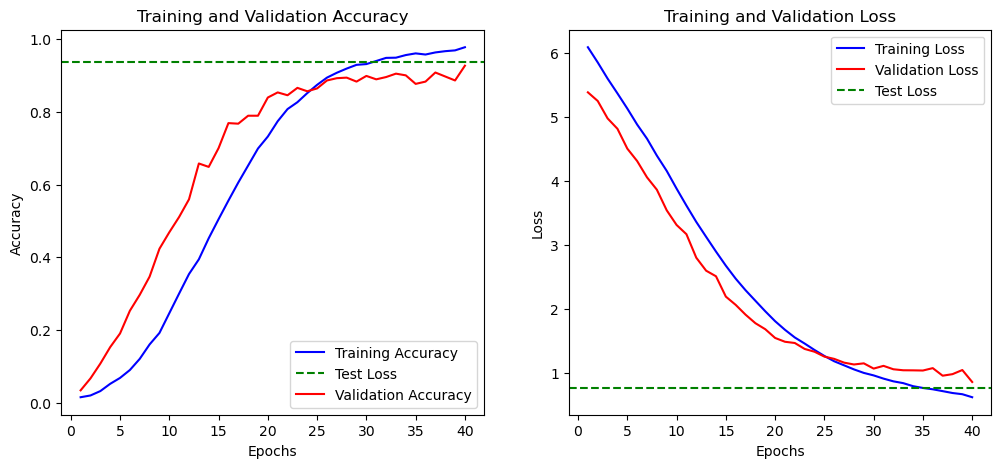

In [8]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    # Get history data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    loss0, accuracy0 = model.evaluate(test_dataset)
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.axhline(y=accuracy0, color='g', linestyle='--', label='Test Loss')  # Green line for test
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.axhline(y=loss0, color='g', linestyle='--', label='Test Loss')  # Green line for test
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to visualize training
plot_history(history)


In [ ]:

loss0, accuracy0 = model.evaluate(val_dataset, steps=validation_steps)
print("VALIDATION")
print(f"Initial Validation Loss: {loss0}")
print(f"Initial Validation Accuracy: {accuracy0}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 917ms/step - accuracy: 0.9112 - loss: 0.9038
VALIDATION
Initial Validation Loss: 0.881588339805603
Initial Validation Accuracy: 0.9140625


In [ ]:

loss0, accuracy0 = model.evaluate(test_dataset)
print("****TEST***")
print(f"Initial Validation Loss: {loss0}")
print(f"Initial Validation Accuracy: {accuracy0}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 917ms/step - accuracy: 0.9359 - loss: 0.8050
****TEST***
Initial Validation Loss: 0.7953768968582153
Initial Validation Accuracy: 0.9373040795326233


In [ ]:
# model.save_weights("E80_D5_LeakyRelu.weights.h5")

In [ ]:
model.save("E40_D5_leakyRelu_150.h5")